## Objectives: 

    1. Import LimnoSat data from R generated .csv 
    2. Generate a function that: 
        a. imports deepest point for each lake in the HydroLAKES dataset 
        b. crops dataset to Colorado boundary
        c. generates a 2km buffer around each deep point (proxy for lake catchment)
        d. checks MTBS shapefile for overlap
        e. saves points that have buffer region that overlaps with MTBS dataframe to a geopandas df
    2. Map data with folium to visualize burned lakes
    3. Classify limnoSAT data as "pre-" or "post-fire"
    4. Generate a 'perimeter score' that indicates how much of perimeters are burned and relative severities
    

Used with earth-analytics environment

# 1.  Import packages

In [1]:
import earthpy as et
import os
import io

import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import ee
import zipfile
import pyproj
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
import matplotlib.pyplot as plt
from functools import partial

# 2. Set Directory

In [2]:
# Set working directory

# if the desired path exists:
data_dir = os.path.join(et.io.HOME, 'Dropbox',
                        'CU Earth DATA Certificate 2021', 'earthlab_project')
if os.path.exists(data_dir):
    # set working directory:
    os.chdir(data_dir)
    print("path exists")
else:
    print("path does not exist, making new path")
    os.makedirs(data_dir)
    os.chdir(data_dir)

path exists


# 3. Add Functions

Some datasets for this project can be downloaded from urls that provide zipped shapefiles.
This function can be used to open these datasets and clip them to desired geographic subset with a shapefile

In [3]:
def open_zips(url, shapefile):
    """opens zipped shapefiles from a url and clips data according to a 
    region of interest defined by a shapefile before saving as a geopandas dataframe
    Parameters
    -----------
    url : path to a zipped shapefile
    shapefile: a shapefile for region of interest

    Returns
    -----------
    gpd : a clipped geopandas geodataframe 
    """
    local_path = 'tmp/'
    print('Downloading shapefile...')
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=local_path)  # extract to folder
    filenames = [y for y in sorted(z.namelist()) for ending in [
        'dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)]
    print(filenames)
    dbf, prj, shp, shx = [filename for filename in filenames]
    gpdfile = gpd.clip(gpd.read_file(
        local_path + shp).to_crs(colo_shp.crs), colo_shp)
    print("Done")
    print("Shape of the dataframe: {}".format(gpdfile.shape))
    print("Projection of dataframe: {}".format(gpdfile.crs))
    return(gpdfile)

# 4. Download Data

## 4a. Download the Colorado shapefile 
to use in clipping the MTBS and HydroLAKES dataset

In [4]:
url = 'https://opendata.arcgis.com/datasets/4402a8e032ed49eb8b37fd729e4e8f03_9.geojson'
colo_shp = gpd.read_file(url)

# Make sure appropriate crs for Colorado distances
colo_shp = colo_shp.to_crs({'init': 'EPSG:32613'})
print("Projection of dataframe: {}".format(colo_shp.crs))

Projection of dataframe: +init=epsg:32613 +type=crs


/Users/laurenkremer/miniconda3/envs/earth-analytics-python/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 4b. Download lake .shps from HydroLAKES
Each entry of the HydroLAKES dataset can be matched to the LimnoSat dataset which provides lake median values for selected Landsat bands for all of the CONUS, via the Hylak_id column. HydroLAKES is the source of lake name and data, including lat-long values for each lake "deep point" as described by Topp et al. 2020. This dataset can be clipped to a Colorado shapefile, and then matched to LimnoSat so that only values that match both dataframes are saved. The GEE script in the link below also contains the lake pour points.

In [5]:
# Download HydroLAKES point data for Colorado
# https://code.earthengine.google.com/4b49c096f90206995d89b87eb528a386
# LimnoSAT deepest points is a Google Earth Engine asset.  This was clipped to
# Colorado boundaries using the script in the link above which exports the asset to Google Drive.

hydro_dp_path = os.path.join("data", "hydro_deep_points_co.shp")
hydro_points = gpd.read_file(hydro_dp_path).to_crs(colo_shp.crs)

In [6]:
# Checking the data format
hydro_points.info() # make sure that Hylak_id is an integer

print("Projection of dataframe: {}".format(hydro_points.crs))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   distance  665 non-null    float64 
 1   type      665 non-null    object  
 2   Hylak_id  665 non-null    int64   
 3   geometry  665 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 20.9+ KB
Projection of dataframe: +init=epsg:32613 +type=crs


**NOT NECESSARY** For grins and visualization, import the HydroLakes shapefile that identifies lake polygons for Colorado

In [7]:
# Download HydroLAKES polygon data for Colorado
#url = 'https://97dc600d3ccc765f840c-d5a4231de41cd7a15e06ac00b0bcc552.ssl.cf5.rackcdn.com/HydroLAKES_polys_v10_shp.zip'
#hydro_polys = open_zips(url, colo_shp)

In [8]:
#hydro_polys.info()

In [9]:
# Export 
#out_path = os.path.join("data", "hydro_polys.shp")
#hydro_polys.to_file(out_path)

## 4c. Download LimnoSat output 
This is a remote sensing dataset for inland waters from cloud-free Landsat observations of U.S. lakes larger than 0.1 km^2.  Reflectance values are extracted from the Chebyshev Center: the  center of the largest circle that can fit entirely within a given polygon's boundary(Topp et al. 2020, Shen et al. 2015) Topp et al. identify this point as the location of the pixel that is furthest away from the lake shoreline (derived from GEE script by Topp et al.) 

In [10]:
# Download LimnoSAT image data

#url = "https://zenodo.org/record/4139695/files/srCorrected_us_hydrolakes_dp_20200628.feather"
#limnosat = pd.read_feather(url)
# Couldn't figure out how to download feather from url. Worked better to download feather locally

limnosat_path = os.path.join(
    "data", "srCorrected_us_hydrolakes_dp_20200628.feather")
limnosat = pd.read_feather(limnosat_path, columns=None,
                           use_threads=True, storage_options=None)

In [11]:
limnosat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22301620 entries, 0 to 22301619
Data columns (total 17 columns):
 #   Column        Dtype   
---  ------        -----   
 0   LandsatID     object  
 1   Hylak_id      float64 
 2   date          object  
 3   Aerosol       float64 
 4   Blue          float64 
 5   Red           float64 
 6   Green         float64 
 7   Nir           float64 
 8   Swir1         float64 
 9   Swir2         float64 
 10  TIR1          float64 
 11  TIR2          float64 
 12  sat           category
 13  pCount_dswe1  float64 
 14  pCount_dswe3  float64 
 15  year          int32   
 16  dWL           float64 
dtypes: category(1), float64(13), int32(1), object(2)
memory usage: 2.6+ GB


## 4d. Download MTBS fire polygons

In [12]:
url = 'https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/composite_data/burned_area_extent_shapefile/mtbs_perimeter_data.zip'
mtbs_polys = open_zips(url, colo_shp)

# Comment out download and use this if running script more than once
# in_path = os.path.join("data", "mtbs_polys.shp")
# mtbs_polys = gpd.read_file(in_path)

['mtbs_perims_DD/mtbs_perims_DD.dbf', 'mtbs_perims_DD/mtbs_perims_DD.prj', 'mtbs_perims_DD/mtbs_perims_DD.shp', 'mtbs_perims_DD/mtbs_perims_DD.shx']
Done
Shape of the dataframe: (377, 23)
Projection of dataframe: +init=epsg:32613 +type=crs


In [13]:
# Write out for future use in other, less memory hungry scripts
#out_path = os.path.join("data", "mtbs_polys.shp")
#mtbs_polys.to_file(out_path)

In [14]:
mtbs_polys.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 377 entries, 151 to 26387
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Event_ID    377 non-null    object  
 1   irwinID     72 non-null     object  
 2   Incid_Name  377 non-null    object  
 3   Incid_Type  377 non-null    object  
 4   Map_ID      377 non-null    int64   
 5   Map_Prog    377 non-null    object  
 6   Asmnt_Type  377 non-null    object  
 7   BurnBndAc   377 non-null    int64   
 8   BurnBndLat  377 non-null    object  
 9   BurnBndLon  377 non-null    object  
 10  Ig_Date     377 non-null    object  
 11  Pre_ID      329 non-null    object  
 12  Post_ID     377 non-null    object  
 13  Perim_ID    89 non-null     object  
 14  dNBR_offst  377 non-null    int64   
 15  dNBR_stdDv  377 non-null    int64   
 16  NoData_T    377 non-null    int64   
 17  IncGreen_T  377 non-null    int64   
 18  Low_T       377 non-null    int64   
 

# 5. Subsetting and Merging to one dataframe

## 5a. Subset LimnoSat dataset for CONUS to Colorado data by matching rows from Colorado 
deep lakes (hydro_points) to whole limnosat dataset, then merge the dataframes to generate
a LimnoSat dataset with deep point geometries.

In [25]:
# conversion of shared column to integer before merging
limnosat['Hylak_id'] = limnosat['Hylak_id'].astype(int)
# = limnosat.loc[limnosat['Hylak_id'] == hydro_points['Hylak_id']]

subset_limno = limnosat[limnosat.set_index(['Hylak_id']).index.isin(
    hydro_points.set_index(['Hylak_id']).index)]  # subset limnoSAT dataset to lake IDs found
# in Colorado HydroLAKES points

In [26]:
#subset_limno.info()

In [27]:
hydro_points.set_index(['Hylak_id'])

# Merge with `merge` method on shared variable (Hylak_id):
limnosat_pnts = hydro_points.merge(subset_limno, on='Hylak_id')

#limnosat_pnts.info()

# Check for an equal area projection that is most accurate to where buffer will be
# https://www.esri.com/news/arcuser/0111/geodesic.html
print("Projection of dataframe: {}".format(limnosat_pnts.crs))

Projection of dataframe: +init=epsg:32613 +type=crs


## 5b.  Generate a 2km buffer around each deep point. This will be a proxy for the lake "catchment"

In [28]:
limnosat_pnts['geometry']=limnosat_pnts.geometry.buffer(2000)

# Drop the points so the script isn't confused later
#limnosat_buffs = limnosat_pnts.drop(['geometry'], axis=1)

In [29]:
limnosat_pnts.dtypes

distance         float64
type              object
Hylak_id           int64
geometry        geometry
LandsatID         object
date              object
Aerosol          float64
Blue             float64
Red              float64
Green            float64
Nir              float64
Swir1            float64
Swir2            float64
TIR1             float64
TIR2             float64
sat             category
pCount_dswe1     float64
pCount_dswe3     float64
year               int32
dWL              float64
dtype: object

In [30]:
# Check to see if this can be exported before merging with MTBS
# but first change catagory datatypes to strings
limnosat_pnts['sat'] = limnosat_pnts['sat'].astype(str)

#out_path = os.path.join("data", "lake_buffers.shp")
#limnosat_buffs.to_file(out_path)

## 5c. Merge buffered lake dataset and MTBS fire dataset

****start rework of merge here.  renaming geometry columns may be messing this up. 
It may be better to generate the merged dataframe
subset some tabular data of merged, then use it to 
subset MTBS and lake buffer datasets.  
This means 3 shapefiles, but may export 

In [31]:
# Function to merge these data frames generates a new polygon, but I want to keep the originals as well
# Merge needs a column named 'geometry'

#mtbs_polys['fire_poly'] = mtbs_polys['geometry']
#limnosat_pnts.head()

In [32]:
merged = gpd.overlay(mtbs_polys, limnosat_pnts, how ='intersection')
#merged_columns_union = gpd.overlay(limno_buffs,just_mtbs_polys,  how ='union')
#merged_union = gpd.overlay(limnosat_pnts,mtbs_polys,  how ='union')
merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 33540 entries, 0 to 33539
Data columns (total 43 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Event_ID      33540 non-null  object  
 1   irwinID       4948 non-null   object  
 2   Incid_Name    33540 non-null  object  
 3   Incid_Type    33540 non-null  object  
 4   Map_ID        33540 non-null  int64   
 5   Map_Prog      33540 non-null  object  
 6   Asmnt_Type    33540 non-null  object  
 7   BurnBndAc     33540 non-null  int64   
 8   BurnBndLat    33540 non-null  object  
 9   BurnBndLon    33540 non-null  object  
 10  Ig_Date       33540 non-null  object  
 11  Pre_ID        27371 non-null  object  
 12  Post_ID       33540 non-null  object  
 13  Perim_ID      10585 non-null  object  
 14  dNBR_offst    33540 non-null  int64   
 15  dNBR_stdDv    33540 non-null  int64   
 16  NoData_T      33540 non-null  int64   
 17  IncGreen_T    33540 non-null  int64   
 18

[None]

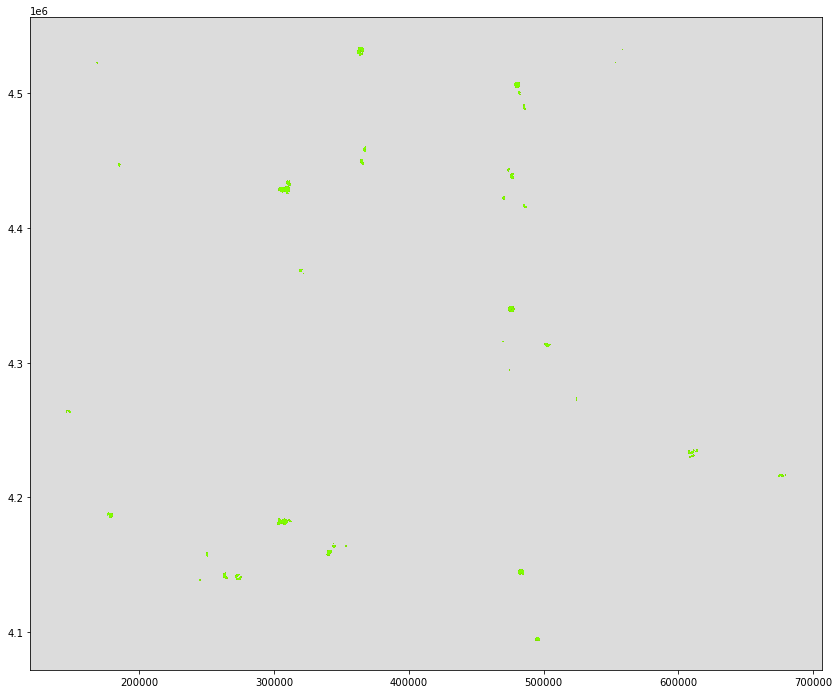

In [34]:
fig, ax = plt.subplots(figsize=(16, 12))

#merged['fire_poly'].plot(ax = ax, 
#                     color='red');

#merged['buffer'].plot(ax=ax, 
#                 color='blue', 
#                 alpha=0.5);

merged['geometry'].plot(ax=ax, color = 'chartreuse', 
            #edgecolor = 'black',
            linewidth = 1,
            alpha=0.5);

ax.set(facecolor = "gainsboro")
#.set_axis_off()

## 5d. Subset to Landsat images taken within 5 years of fire
This dataset covers a long period of time. I am really only interested in maybe 5-10 years post fire. To subset images (dataframe rows) by days before/after fire:

In [35]:
# 1. Make sure desired dates are in date format
merged['date'] = pd.to_datetime(merged['date'])
merged['Ig_Date'] = pd.to_datetime(merged['Ig_Date'])
merged.Ig_Date

# 2. Set a column to identify images as pre- or post-fire
merged['pre_post'] = np.where(
    merged['date'] < merged['Ig_Date'], "pre-fire", "post-fire")

# 3. Generate a calculation for the lapse of time pre- or post fire for plotting
merged['days_since'] = (merged['date'] - merged['Ig_Date'])
# print(merged.days_since)

# 4. Convert days_since to numerical/integer value that can be indexed and plotted
merged.days_since = merged.days_since.astype('timedelta64[D]').astype(int)

# 5. Add a image month column for trend monitoring
merged['img_month'] = pd.DatetimeIndex(merged['date']).month

# 6. Assuming that I want to look at trends 5 years pre and post fire - subset days to |1825|
merged = merged.loc[(merged['days_since'] < 3650) &
                    (merged['days_since'] > -1825)]

# Check that new or converted values make sense
print(merged[['Ig_Date', 'date', 'pre_post', 'days_since', 'img_month']])

         Ig_Date       date   pre_post  days_since  img_month
69    2012-06-23 2007-07-16   pre-fire       -1804          7
70    2012-06-23 2007-08-01   pre-fire       -1788          8
71    2012-06-23 2007-09-18   pre-fire       -1740          9
72    2012-06-23 2007-10-04   pre-fire       -1724         10
73    2012-06-23 2007-10-20   pre-fire       -1708         10
...          ...        ...        ...         ...        ...
33535 2018-07-19 2018-06-02   pre-fire         -47          6
33536 2018-07-19 2018-06-18   pre-fire         -31          6
33537 2018-07-19 2019-06-05  post-fire         321          6
33538 2018-07-19 2019-07-23  post-fire         369          7
33539 2018-07-19 2020-05-22  post-fire         673          5

[15325 rows x 5 columns]


# 6. Export the data

# **** Here is a subset of the 'merged' dataframe that contains the problem geometries.
# 'merged' has three geometry columns:
-'fire_polys' which is the polygon from the MTBS dataset

-'buffer', which is the polygon generated from a 2km buffer around lake points (from limnosat_buffs)

-'geometry', which is the polygon that represents the overlap between the fire polygon and the lake
buffer

'geometry' seems to export OK, but the other two do not. 

In [39]:
# The resulting geometry in the new dataframe is a new polygon that identifies overlap. 

# Cannot seem to export this dataframe as one file.  Contains objects, integers, floats, geometries...
# so try separating by type to export

merged_geo = gpd.GeoDataFrame(merged[['Hylak_id','geometry']].copy())
#merged_geo['Hylak_id'] = merged_geo.Hylak_id.astype('str')
merged_geo = merged_geo.iloc[0:1,]

#merged[merged['buffer'].isna()==True]
#merged[merged['buffer'].is_valid==False]
#merged[merged['buffer'].is_empty==True]

#merged_geo['geometry']= merged_geo['fire_poly']
merged_geo.info
merged_geo.columns

merged_geo.geom_type
pd.unique(merged_geo.geom_type)

array(['Polygon'], dtype=object)

In [40]:
print(merged_geo.info())
print(merged_geo.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1 entries, 69 to 69
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Hylak_id  1 non-null      int64   
 1   geometry  1 non-null      geometry
dtypes: geometry(1), int64(1)
memory usage: 24.0 bytes
None
    Hylak_id                                           geometry
69    112400  POLYGON ((501094.073 4314251.098, 501143.294 4...


In [41]:
outfp = os.path.join("data", "lake_mtbs_merged_geo.shp")
merged_geo.to_file(outfp)

In [44]:
# Make a copy of the geopandas dataframe
merged1 = merged.copy()

# Designate desitnation path
outfp = os.path.join("data", "lake_mtbs_merged_tab.csv")

# Export tabular data after dropping troublesome geometry columns
merged1.drop(columns = ['geometry']).to_csv(outfp)

In [ ]:
import folium

map = folium.Map(location=[39.201, -105.9230])
#ax = just_mtbs_polys.plot(color='red');
#limnosat_buffs.plot(ax=ax, color='blue', alpha=0.5);
#merged.plot(ax=ax, color='green', alpha=0.5);

for _, row in merged.iterrows():
    sim_geo = gpd.GeoSeries(row['buffer']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'red', 'color': 'red'})
    #folium.Popup(r['Incid_Name']).add_to(geo_j)
    geo_j.add_to(map)

for _, row in merged.iterrows():
    sim_geo = gpd.GeoSeries(row['fire_poly']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'blue', 'color': 'blue'})
    #folium.Popup(r['Hylak_id']).add_to(geo_j)
    geo_j.add_to(map)

for _, row in merged.iterrows():
    sim_geo = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'chartruse', 'color': 'yellow'})
    #folium.Popup(r['Hylak_id']).add_to(geo_j)
    geo_j.add_to(map)


map